In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from xmitgcm import open_mdsdataset

In [2]:
outdir = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL_SVB/01_SVB_febTS_output/'

levels = [1,   2,  3,  4,  5,  6,  7,  8,  9, 10, 
          11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25,
          26, 27, 28, 29, 30, 31,
          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,              
          58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 
          74, 79, 84, 89, 94, 99,]
ds = open_mdsdataset(outdir, prefix=['eta','dynVars'], levels=levels)


In [3]:
depth_bay = ds.Depth[:]
LAT = ds['YC'][:]
LON = ds['XC'][:]-360
lat = ds.YC[:,0].data
lon = ds.XC[0,:].data-360

Z = ds['Z'][:]
Zl = ds['Zl'][:]

# centers mask
hFacC = ds['hFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
dep_masked = np.ma.masked_values(depth_bay,0)
mask_dep = np.ma.getmask(dep_masked)
time = np.arange(0,720)*600

In [49]:
def unstagger(ugrid, vgrid):
    """ Interpolate u and v component values to values at grid cell centres (from D.Latornell for NEMO output).
    The shapes of the returned arrays are 1 less than those of
    the input arrays in the y and x dimensions.
    :arg ugrid: u velocity component values with axes (..., y, x)
    :type ugrid: :py:class:`numpy.ndarray`
    :arg vgrid: v velocity component values with axes (..., y, x)
    :type vgrid: :py:class:`numpy.ndarray`
    :returns u, v: u and v component values at grid cell centres
    :rtype: 2-tuple of :py:class:`numpy.ndarray`
    """
    u = np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2
    v = np.add(vgrid[..., :-1, :], vgrid[..., 1:, :]) / 2
    return u, v

def get_snapshot_at_level(ds,tt,zz,fld):
    W = ds[fld][tt,zz,:,:]
    return(W)

def get_eta_snapshot(ds,tt,fld):
    W = ds[fld][tt,:,:]
    return(W)

def plot_field_w(ax,tt,lon,lat,eta,time,mask,zind,
                 cmap=cmo.cm.rain,vmin=-0.3, vmax=0.3, title=' ', cbar=False,label='cm'):
    ax.set_facecolor('tan')
    levs = np.linspace(vmin,vmax,60)
    pc = ax.contourf(lon,lat, 
                     np.ma.masked_array(eta,mask=mask[zind,:,:]),
                     levels=levs,
                     cmap=cmap, vmin=vmin, vmax=vmax, extend='both')
      
    if cbar==True:
        #cbar_ax = fig.add_axes([0.35, 0.82, 0.5, 0.04]) 
        cb = fig.colorbar(pc,ax=ax,
                          orientation='horizontal', 
                          format='%1.1f', label=label,
                          extend='both', ticks=[-1.2,-0.8,-0.4,0,0.4,0.8,1.2])
    
        #norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        #cbar_ax = fig.add_axes([0.45, 0.8, 0.38, 0.05]) 
        #cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
        #                  cax=cbar_ax, orientation='horizontal', 
        #                  format='%1.1f', label='SSH (cm)')
    
    ax.set_title('%s t=%1.1f h'%(title,time[tt]/3600))
    ax.set_aspect(1)
    return(ax)
def plot_quiver(ax,lon,lat,u,v):
    ax.quiver(lon,lat,u,v)
    return ax

def init():
    tt=0
    Wbay1 = get_eta_snapshot(ds, tt, 'ETAN')
    W1 = get_snapshot_at_level(ds, tt, zz, 'WVEL')
    U1 = get_snapshot_at_level(ds, tt, zz, 'UVEL')
    V1 = get_snapshot_at_level(ds, tt, zz, 'VVEL')
     
    UU,VV = unstagger(U1[1:-1,:],V1[:,1:-1])       
    uu = np.ma.masked_array(UU, mask=mask[zz,1:-1,1:-1])
    vv = np.ma.masked_array(VV, mask=mask[zz,1:-1,1:-1])
    
    axx= plot_field_w(ax1,tt,lon,lat,(Wbay1)*1E2,time,
                      mask,zz,cmap=cmap, vmin=-1.2, vmax=1.2,cbar=True, title='SSH')
    ax1.contour(lon, lat, depth_bay, levels=[0, 200, 400, 600, 800, 1000],
                colors=['0.5','0.5','0.5','0.5','0.5','0.5'], alpha=0.1)
    axx= plot_field_w(ax2,tt,lon,lat,(W1)*1E5,time,
                      mask,zz,cmap=cmo.cm.balance, vmin=-1, vmax=1,cbar=True, 
                      title='w', label=r'10$^{-5}$ m/s')
    ax2.contour(lon, lat, depth_bay, levels=[0, 200, 400, 600, 800, 1000],
                colors=['0.5','0.5','0.5','0.5','0.5','0.5'], alpha=0.1)
    
    plot_quiver(ax2,lon[1:-1:10],lat[1:-1:10],uu[::10,::10],vv[::10,::10])
    
    ax1.set_xlabel('lon')
    ax1.set_ylabel('lat')
    ax2.set_xlabel('lon')
    
def animate(t):
    tt=t
    #tt=t
    print(tt)
    Wbay1 = get_eta_snapshot(ds, tt, 'ETAN')
    W1 = get_snapshot_at_level(ds, tt, zz, 'WVEL')
    U1 = get_snapshot_at_level(ds, tt, zz, 'UVEL')
    V1 = get_snapshot_at_level(ds, tt, zz, 'VVEL')
     
    UU,VV = unstagger(U1[1:-1,:],V1[:,1:-1])       
    uu = np.ma.masked_array(UU, mask=mask[zz,1:-1,1:-1])
    vv = np.ma.masked_array(VV, mask=mask[zz,1:-1,1:-1])
    
    axx= plot_field_w(ax1,tt,lon,lat,(Wbay1)*1E2,time,
                      mask,zz,cmap=cmap, vmin=-1.2, vmax=1.2,cbar=False, title='SSH at SVB')
    ax1.contour(lon, lat, depth_bay, levels=[0, 200, 400, 600, 800, 1000],
                colors=['0.5','0.5','0.5','0.5','0.5','0.5'], alpha=0.1)
    axx= plot_field_w(ax2,tt,lon,lat,(W1)*1E5,time,
                      mask,zz,cmap=cmo.cm.balance, vmin=-1, vmax=1,cbar=False, 
                      title='w at SVB', label=r'10$^-5$ m/s')
    ax2.contour(lon, lat, depth_bay, levels=[0, 200, 400, 600, 800, 1000],
                colors=['0.5','0.5','0.5','0.5','0.5','0.5'], alpha=0.1)
    plot_quiver(ax2,lon[1:-1:10],lat[1:-1:10],uu[::10,::10],vv[::10,::10])
    
    ax1.set_xlabel('lon')
    ax1.set_ylabel('lat')
    ax2.set_xlabel('lon')

In [47]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=4, metadata=dict(artist='KRM'), bitrate=300)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


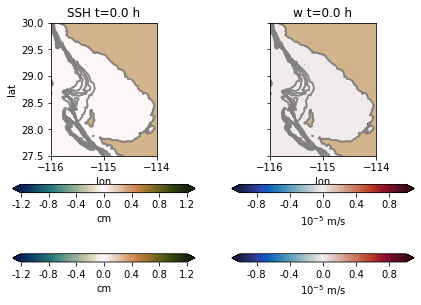

In [51]:
cmap=cmo.cm.tarn_r
zz = 0
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(7.2,5), sharex=True, sharey=True)
ax1.set_xlim(-116, -114)
ax1.set_ylim(27.5, 30)
# Uncomment lines below to run and save animation
anim = animation.FuncAnimation(fig, animate, init_func=init, blit=False,
                               frames=20, repeat=False)
anim.save('SVB_seiche_all.mov', writer=writer, dpi=500)

In [ ]:
tt=23
plt.pcolormesh(lon,lat,ds['ETAN'][tt,:,:], cmap=cmo.cm.tarn)
plt.xlim(-116,-114)
plt.ylim(27.5,30)
plt.title('%1.1f' %(time[tt]/3600))

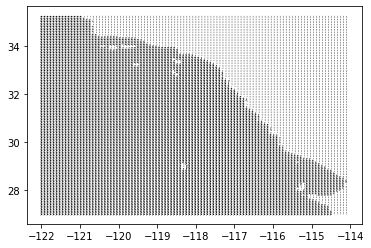

In [45]:
U1 = get_snapshot_at_level(ds, 50, 0, 'UVEL')
V1 = get_snapshot_at_level(ds, 50, 0, 'VVEL')
UU,VV = unstagger(U1[1:-1,:],V1[:,1:-1])    

lon2 = lon[1:-1]
lat2 = lat[1:-1]
plt.quiver(lon2[::5],lat2[::10],UU[::5,::5],VV[::5,::5])

In [44]:
lat.shape

(612,)

In [35]:
ds.VVEL

<xarray.DataArray 'VVEL' (time: 720, k: 76, j_g: 612, i: 512)>
dask.array<concatenate, shape=(720, 76, 612, 512), dtype=float64, chunksize=(1, 76, 612, 512), chunktype=numpy.ndarray>
Coordinates: (12/15)
  * i        (i) int64 0 1 2 3 4 5 6 7 8 ... 503 504 505 506 507 508 509 510 511
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 ... 604 605 606 607 608 609 610 611
  * k        (k) int64 1 2 3 4 5 6 7 8 9 10 11 ... 67 68 69 70 74 79 84 89 94 99
    Z        (k) >f8 dask.array<chunksize=(76,), meta=np.ndarray>
    dxG      (j_g, i) >f8 dask.array<chunksize=(612, 512), meta=np.ndarray>
    dyC      (j_g, i) >f8 dask.array<chunksize=(612, 512), meta=np.ndarray>
    ...       ...
    hFacS    (k, j_g, i) >f8 dask.array<chunksize=(76, 612, 512), meta=np.ndarray>
    maskS    (k, j_g, i) bool dask.array<chunksize=(76, 612, 512), meta=np.ndarray>
    rhoRef   (k) >f8 dask.array<chunksize=(76,), meta=np.ndarray>
    maskInS  (j_g, i) bool dask.array<chunksize=(612, 512), meta=np.ndarray>
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) timedelta64[ns] 00:00:10 00:00:20 ... 01:59:50 02:00:00